# imports

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile as zp
import torchvision.transforms as transforms

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torchvision

import torch.utils.data as data
import torch.nn.functional as F
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tqdm.notebook import trange,tqdm_notebook   #tqdm is a library that is used for creating Python Progress Bars
from tqdm import tqdm
import time
import random
import numpy as np

# zipfile extraction

In [6]:
# we have extracted the zip file and placed the contents in a folder.

zip_path = r"cnn_dataset.zip"   # dynamic- change for online runs (colab/kaggle/aws)
data_path = r"images"

with zp(file=zip_path,mode="r") as obj :
    obj.extractall(path=data_path)
obj.close()



In [7]:
# types of data/ datalabels we have
data_labels = os.listdir(path=data_path)
data_labels

['dogs', 'food', 'vehicles']

In [8]:
images_list = []   # This list will save type of image and image path 

for labels in data_labels:
    lables_class = os.listdir(path=data_path+"/"+ labels)
    for img in lables_class:
#         print(labels, img)
#         print(labels, data_path+"\\"+labels+"\\"+img)
        images_list.append((labels, data_path+"\\"+labels+"\\"+img))

# print(images_list)

In [9]:
df = pd.DataFrame(data = images_list,columns=["class" , "image_path"])
display(df.head())
df["class"].value_counts()

# we have 3 classes with each of 10,000 images 

,class,image_path
0,dogs,images\dogs\4791.jpg
1,dogs,images\dogs\961.jpg
2,dogs,images\dogs\6657.jpg
3,dogs,images\dogs\6509.jpg
4,dogs,images\dogs\1255.jpg


dogs        10000
food        10000
vehicles    10000
Name: class, dtype: int64

# Dataset Visualization and statistics

In [10]:
import cv2
random_pick = list(map(lambda x: df.iloc[x] , [k for k in random.sample(range(len(df)),10)]))

In [11]:
def plot_random_images(iterator):   #iterator has image paths  
    
    plt.figure(figsize=(20,20))
    plt.subplot(331)
    plt.title(iterator[0][0])
    plt.imshow(cv2.imread(iterator[0][1]))
    plt.subplot(332)
    plt.title(iterator[1][0])
    plt.imshow(cv2.imread(iterator[1][1]))
    plt.subplot(333)
    plt.title(iterator[2][0])
    plt.imshow(cv2.imread(iterator[2][1]))
    plt.subplot(334)
    plt.title(iterator[3][0])
    plt.imshow(cv2.imread(iterator[3][1]))
    plt.subplot(335)
    plt.title(iterator[4][0])
    plt.imshow(cv2.imread(iterator[4][1]))
    plt.subplot(336)
    plt.title(iterator[5][0])
    plt.imshow(cv2.imread(iterator[5][1]))
    plt.subplot(337)
    plt.title(iterator[6][0])
    plt.imshow(cv2.imread(iterator[6][1]))
    plt.subplot(338)
    plt.title(iterator[7][0])
    plt.imshow(cv2.imread(iterator[7][1]))
    plt.subplot(339)
    plt.title(iterator[8][0])
    plt.imshow(cv2.imread(iterator[8][1]))
    plt.show()

plot_random_images(iterator=random_pick)

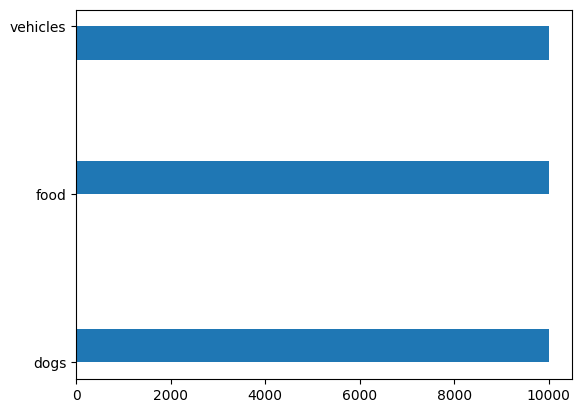

In [12]:
plt.hist(df["class"],orientation="horizontal",align="mid")
plt.show()

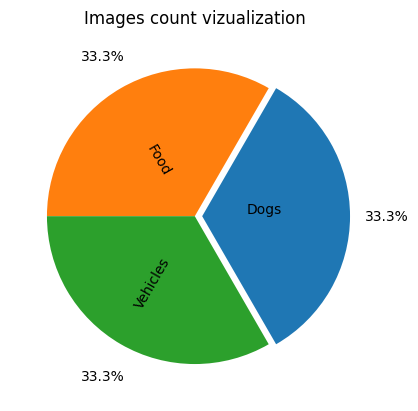

In [13]:
lables_class = ["Dogs","Food","Vehicles"]

figure, axis = plt.subplots()
axis.pie(df["class"].value_counts(),labels=lables_class,autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=0.3,rotatelabels=20,explode=(0.05,0,0),startangle=300)
plt.title("Images count vizualization")
plt.show()

# Image preprocessing 

In [14]:
from PIL import Image
from numpy import asarray

## Normalization using transforms

In [15]:
#using the Imagenet pretrianed model with its own mean and std is recommended!

transform_var = transforms.Compose([ transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),])   # These mean and sd are taken from ImageNet

## Loading the data using Dataloaders and splitting it into test/train/validation sets

In [16]:
from torchvision.datasets import ImageFolder

In [17]:
# data_path is the root where we have extracted the dataset.zip file

image_data = ImageFolder(root=data_path,transform=transform_var)   

In [18]:
print(f"Length of Dataset is : {len(image_data)}")

length_train_data = int(0.8*len(image_data))
length_test_data = len(image_data)- length_train_data
length_validation_data = int(0.1*length_train_data)
print("*"*50)
print(f"Length of Training data : {length_train_data}")
print(f"Length of Testing data : {length_test_data}")
print(f"Length of validation data : {length_validation_data} = 10% of train data")
print("*"*50)

Length of Dataset is : 30000
**************************************************
Length of Training data : 24000
Length of Testing data : 6000
Length of validation data : 2400 = 10% of train data
**************************************************


# splitting data into test and train datasets

In [19]:
train_dataset,test_dataset = torch.utils.data.dataset.random_split(dataset=image_data,lengths=[length_train_data,length_test_data])

In [20]:
length_train_data = int(0.9*0.8*len(image_data))   # splitting train dataset to train and validation datset

In [21]:
train_dataset,validation_dataset = torch.utils.data.dataset.random_split(dataset=train_dataset,lengths=[length_train_data,length_validation_data])

In [22]:
print(f"Length of Dataset  : {len(image_data)}")
print("*"*50)
print(f"Length of Training data : {len(train_dataset)}")
print(f"Length of Testing data : {len(test_dataset)}")
print(f"Length of validation data : {len(validation_dataset)}")
print("*"*50)

Length of Dataset  : 30000
**************************************************
Length of Training data : 21600
Length of Testing data : 6000
Length of validation data : 2400
**************************************************


# Dataloaders 

# using iterators to run the data in batches 
#### (useful for dealing with memory problem)

In [23]:
batch_size_var = 64

train_loader = torch.utils.data.DataLoader(dataset= train_dataset, batch_size=batch_size_var,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(dataset= test_dataset, batch_size=batch_size_var,
                                          shuffle=False, num_workers=0)

validation_loader = torch.utils.data.DataLoader(dataset= validation_dataset, batch_size=batch_size_var,
                                          shuffle=False, num_workers=0)

In [24]:
len(train_loader)

338

# Using pytorch and Alex

In [25]:
#all imports given in 2nd block

## Random seed is set to 69 to reproduce results under same seeding conditions

In [26]:
seed_var = 69
random.seed(seed_var)
np.random.seed(seed_var)
torch.manual_seed(seed_var)
torch.cuda.manual_seed(seed_var)
torch.backends.cudnn.deterministic = True

In [27]:
class_count = 3

In [28]:
# Alexnet code implementation!

class AlexNet(nn.Module):
  def __init__(self, output_class = class_count):
      super().__init__()
      self.features = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

          nn.Conv2d(in_channels=96, out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

          nn.Conv2d(in_channels=192, out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),

          nn.Conv2d(in_channels=384, out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          
          nn.Conv2d(in_channels=256, out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
          )
      
      self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
      self.classifier = nn.Sequential(
          nn.Dropout(),
          nn.Linear(in_features=256*6*6,out_features=4096),
          nn.ReLU(inplace=True),
          nn.Dropout(),
          nn.Linear(in_features=4096,out_features=4096),
          nn.ReLU(inplace=True),
          nn.Linear(in_features=4096,out_features=output_class),
        )
      
  def forward(self,x):
    x = self.features(x)
    x = self.avgpool(x)
#     print(f"Shape of input after 5 Convolution layers : {x.shape}")
    x = x.view(x.size(0),256*6*6) 
#     print(f"Shape of x after viewing : {x.shape}")
    x = self.classifier(x)
    return x


In [29]:
# Funtion to count the trainable parameters in a model

def params_count(model):
    count = 0
    for parms in model.parameters():
        if parms.requires_grad:
            count+=parms.numel()
    
    print(f"The given model has {count} parameters to train")
    return count

# Model initiallized

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_alex = AlexNet(output_class=3).to(device)

In [31]:
#parameter count 
params_count(model_alex)

The given model has 57180195 parameters to train


57180195

In [32]:
# function to calculate accuracy

def model_accuracy(y_true,y_pred):
    y_hat = y_pred.argmax(1,keepdim=True)
#     print("y_pred",y_pred)
    
    count = y_hat.eq(y_true.view_as(y_hat)).sum()
#     print("count",count)
    acc = count.float()/y_true.shape[0]
    return acc

# parameters to optimize/ adjust / initiallize

In [33]:
# optimizer = optim.Adam(model_alex.parameters(),lr=0.001)
optimizer = optim.SGD(model_alex.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_alex = model_alex.to(device)

In [34]:
# function for Training the model

def trainModel(model,iterator,optimizer,criterion,device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for x,y in iterator:
        x = x.to(device)   # images
        y = y.to(device)   # class - labels
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        loss = criterion(y_pred,y)
        acc = model_accuracy(y_true=y,y_pred=y_pred)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    loss_var = epoch_loss/len(iterator)
    acc_var = epoch_acc/len(iterator)
    return epoch_loss/len(iterator) , epoch_acc/len(iterator)

In [35]:
# function for Testing the model

def evaluateModel(model,iterator,optimizer,criterion,device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad(): 
        for x,y in iterator:
            x = x.to(device)
            y = y.to(device)
#             optimizer.zero_grad()

            y_pred = model(x)

            loss = criterion(y_pred,y)
            acc = model_accuracy(y_true=y,y_pred=y_pred)

#             loss.backward()
#             optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator) , epoch_acc/len(iterator)

In [36]:
# function to calculate training and testing times

def time_stamps(st,et,name_tag = ""):  # start time:st ; end time :et
    run_time = -(st - et)
    run_time_mins = int(run_time/60)
    run_time_sec = int(run_time - run_time_mins*60)
    print()
    print(f"Elapsed time for {name_tag} is {run_time_mins} mins and {run_time_sec} seconds \n")
    return run_time
    

In [37]:
# useful for creating python progress bars
from tqdm import trange
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm


In [38]:
num_epochs = 12
loss_best = float("inf")   # infinity
run_time_train_lst = []
run_time_test_lst = []
loss_train_list, loss_valid_list, loss_test_list = [],[],[]
acc_train_list, acc_valid_list, acc_test_list = [],[],[]


for epoch in range(num_epochs):
    start_time = time.monotonic()
    
    train_loss,train_acc = trainModel(model=model_alex,iterator=train_loader,optimizer=optimizer,criterion=criterion,device=device)
    validation_loss,validation_acc = evaluateModel(model=model_alex,iterator=validation_loader,optimizer=None,criterion=criterion,device=device)
    loss_train_list.append(train_loss)
    loss_valid_list.append(validation_loss)
    acc_train_list.append(train_acc)
    acc_valid_list.append(validation_acc)


    if validation_loss < loss_best :
        loss_best = validation_loss
        torch.save(model_alex.state_dict(),"model_best_state.pt")
        
    end_time = time.monotonic()
    
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Training and validation")
    run_time_train_lst.append(run_time)
    
    
    # testing using saved model state
#     model_alex.load_state_dict(torch.load("model_best_state.pt"))  # we will use this state to run after running all epochs
    
    start_time = time.monotonic()
    
    test_loss,test_acc = evaluateModel(model=model_alex,iterator=test_loader,optimizer=None,criterion=criterion,device=device)
    loss_test_list.append(test_loss)
    acc_test_list.append(test_acc)

    end_time = time.monotonic()
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Testing")
    run_time_test_lst.append(run_time)

    print("*"*60)
    print(f"Epoch : {epoch}")
    print("*"*60)
    print(f"Train accuracy : {train_acc :.2f} | Train loss : {train_loss :.2f}")
    print(f"Validation accuracy : {validation_acc:.2f} | validation loss : {validation_loss:.2f}")
    print(f"Test accuracy : {test_acc :.2f} | Test loss : {test_loss :.2f}")
    print("*"*60)
    print()
run_time_lst = run_time_train_lst + run_time_test_lst
print(f"Total run time for all epochs is : {sum(run_time_lst)} | specific : {int(sum(run_time_lst)/60)} minutes and {sum(run_time_lst) - int(sum(run_time_lst)/60)*60} seconds ")


Elapsed time for Training and validation is 0 mins and 52 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 0
************************************************************
Train accuracy : 0.68 | Train loss : 0.69
Validation accuracy : 0.81 | validation loss : 0.58
Test accuracy : 0.81 | Test loss : 0.56
************************************************************


Elapsed time for Training and validation is 0 mins and 45 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 1
************************************************************
Train accuracy : 0.84 | Train loss : 0.41
Validation accuracy : 0.87 | validation loss : 0.34
Test accuracy : 0.86 | Test loss : 0.34
************************************************************


Elapsed time for Training and validation is 0 mins and 44 seconds 


Elapsed time for Testing is 0 

In [39]:
def model_predict(model,iter_obj,device):
  model.eval()
  im,lbs,pr = [],[],[]

  with torch.no_grad():
    for x,y in iter_obj:
      x = x.to(device)
      y_pred = model(x)
      y_prob = torch.nn.functional.softmax(y_pred,dim=-1)

      im.append(x.cpu())
      lbs.append(y.cpu())
      pr.append(y_prob.cpu())

  im = torch.cat(im,dim=0)
  lbs = torch.cat(lbs,dim=0)
  pr = torch.cat(pr,dim=0)

  return im,lbs,pr,y_pred,y

In [40]:
i,j,k,l,m = model_predict(model=model_alex,iter_obj=test_loader,device=device)

In [41]:
pred_labels = torch.argmax(k,1)
pred_labels

tensor([1, 2, 0,  ..., 0, 0, 1])

# Confusion Matrix

In [42]:
def plot_cm(labels,pred_labels,data_labels):
    figure = plt.figure(figsize=(8,8))
    axis = figure.add_subplot(1,1,1)
    cm = confusion_matrix(y_true=labels,y_pred=pred_labels)
    cm = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=data_labels)
    cm.plot(values_format="d",ax=axis,cmap="PuBuGn")
    plt.xticks(rotation=30)
    plt.yticks(rotation=30)
    figure.show()

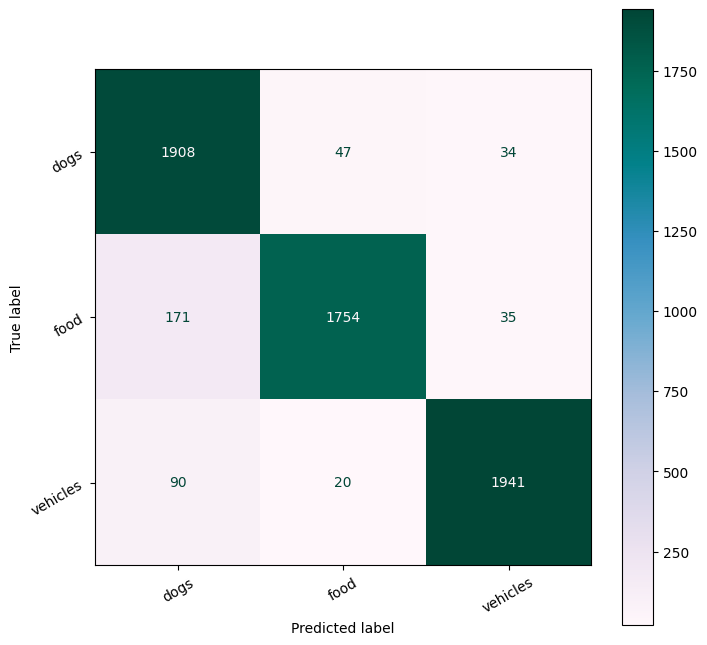

In [43]:
plot_cm(j,pred_labels,data_labels)

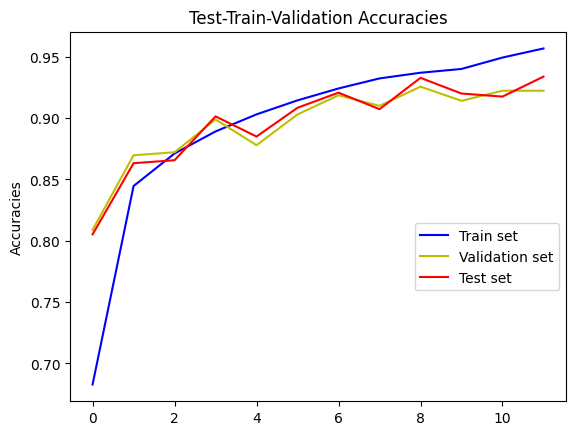

In [44]:
x_axis = range(num_epochs)
plt.ylabel("Accuracies")
plt.xlabel = "Number of Epochs"
plt.title("Test-Train-Validation Accuracies")
plt.plot(x_axis,acc_train_list,color="b",label="Train set")
plt.plot(x_axis,acc_valid_list,color="y",label="Validation set")
plt.plot(x_axis,acc_test_list,color="r",label="Test set")
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()

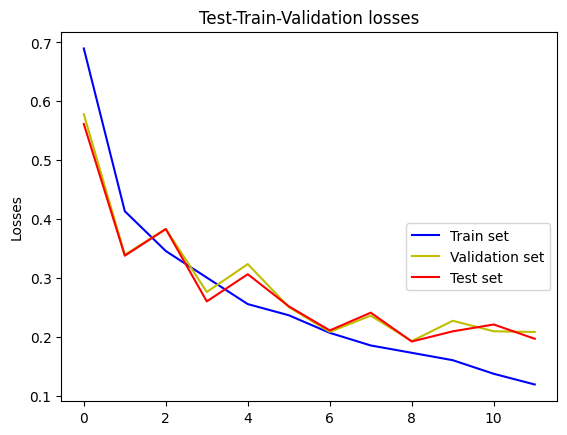

In [45]:
x_axis = range(num_epochs)
plt.ylabel("Losses")
plt.xlabel = "Number of Epochs"
plt.title("Test-Train-Validation losses")
plt.plot(x_axis,loss_train_list,color="b",label="Train set")
plt.plot(x_axis,loss_valid_list,color="y",label="Validation set")
plt.plot(x_axis,loss_test_list,color="r",label="Test set")
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()

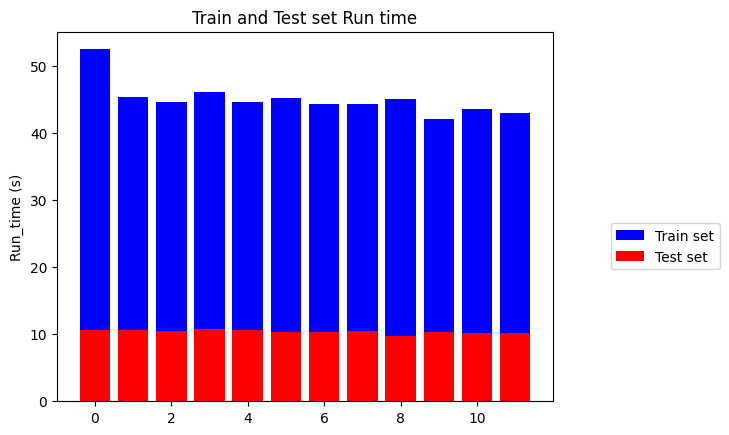

In [46]:
x_axis = range(num_epochs)
plt.ylabel("Run_time (s)")
plt.xlabel = "Number of Epochs"
plt.title("Train and Test set Run time")  # Train run time includes validation too
plt.bar(x_axis,run_time_train_lst,color="b",label="Train set")
# plt.plot(x_axis,loss_valid_list,color="y",label="Validation set")
plt.bar(x_axis,run_time_test_lst,color="r",label="Test set")
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.85, 0.5))
plt.show()

## This Assignment takes heavy computational load which lead to runtime crash multiple time halting progress

## we are saving results to file which can be used later on!

In [49]:
vars_file_path = "vars_file"

In [50]:
with open(vars_file_path,mode = "a") as fp:
    fp.write("\n")
    fp.write(f"Base Model\n")
    fp.write(f"Training loss :{loss_train_list}\n")
    fp.write(f"Validation loss :{loss_valid_list}\n")
    fp.write(f"Testing loss :{loss_test_list}\n")
    fp.write("\n")
    fp.write(f"Training Accuracy :{acc_train_list}\n")
    fp.write(f"Validation Accuracy :{acc_valid_list}\n")
    fp.write(f"Testing Accuracy :{acc_test_list}\n")
    fp.write("\n")
    fp.write(f"Training Runtime :{run_time_train_lst}\n")
    fp.write(f"Testing Runtime :{run_time_test_lst}\n")
    fp.write(f"Total Runtime :{sum(run_time_lst)}\n")


    fp.write("\n")


# Improvized model 1 : Weights Initializer using kaiming and xavier normal dist

In [51]:
# The modification follows same architecture of AlexNet as base model

model_alex_1 = AlexNet(output_class=3).to(device)

# Function to initialize parameters
def params_initialization(layer):
    if isinstance(layer,nn.Conv2d):
        print(type(layer),"True")
        nn.init.kaiming_normal_(layer.weight.data , nonlinearity="relu")
        nn.init.constant_(layer.bias.data,val=0)
    elif isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight.data,gain=nn.init.calculate_gain("relu"))
        nn.init.constant_(layer.bias.data,val=0)

params_initialization(model_alex_1)

# optimizer = optim.Adam(model_alex.parameters(),lr=0.001)
optimizer = optim.SGD(model_alex_1.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_alex_1 = model_alex_1.to(device)

num_epochs = 12
loss_best = float("inf")   # infinity
run_time_train_lst1 = []
run_time_test_lst1 = []
loss_train_list1, loss_valid_list1, loss_test_list1 = [],[],[]
acc_train_list1, acc_valid_list1, acc_test_list1 = [],[],[]


for epoch in range(num_epochs):
    start_time = time.monotonic()
    
    train_loss,train_acc = trainModel(model=model_alex_1,iterator=train_loader,optimizer=optimizer,criterion=criterion,device=device)
    validation_loss,validation_acc = evaluateModel(model=model_alex_1,iterator=validation_loader,optimizer=None,criterion=criterion,device=device)
    loss_train_list1.append(train_loss)
    loss_valid_list1.append(validation_loss)
    acc_train_list1.append(train_acc)
    acc_valid_list1.append(validation_acc)


    if validation_loss < loss_best :
        loss_best = validation_loss
        torch.save(model_alex_1.state_dict(),"model_best_state_1.pt")
        
    end_time = time.monotonic()
    
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Training and validation")
    run_time_train_lst1.append(run_time)
    
    
    # testing using saved model state
#     model_alex_1.load_state_dict(torch.load("model_best_state.pt"))  # we will use this state to run after running all epochs
    
    start_time = time.monotonic()
    
    test_loss,test_acc = evaluateModel(model=model_alex_1,iterator=test_loader,optimizer=None,criterion=criterion,device=device)
    loss_test_list1.append(test_loss)
    acc_test_list1.append(test_acc)

    end_time = time.monotonic()
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Testing")
    run_time_test_lst1.append(run_time)

    print("*"*60)
    print(f"Epoch : {epoch}")
    print("*"*60)
    print(f"Train accuracy : {train_acc :.2f} | Train loss : {train_loss :.2f}")
    print(f"Validation accuracy : {validation_acc:.2f} | validation loss : {validation_loss:.2f}")
    print(f"Test accuracy : {test_acc :.2f} | Test loss : {test_loss :.2f}")
    print("*"*60)
    print()
run_time_lst1 = run_time_train_lst1 + run_time_test_lst1
print(f"Total run time for all epochs is : {sum(run_time_lst1)} | specific : {int(sum(run_time_lst1)/60)} minutes and {sum(run_time_lst1) - int(sum(run_time_lst1)/60)*60} seconds ")


Elapsed time for Training and validation is 0 mins and 44 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 0
************************************************************
Train accuracy : 0.67 | Train loss : 0.74
Validation accuracy : 0.82 | validation loss : 0.50
Test accuracy : 0.81 | Test loss : 0.49
************************************************************


Elapsed time for Training and validation is 0 mins and 45 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 1
************************************************************
Train accuracy : 0.83 | Train loss : 0.44
Validation accuracy : 0.87 | validation loss : 0.37
Test accuracy : 0.87 | Test loss : 0.35
************************************************************


Elapsed time for Training and validation is 0 mins and 46 seconds 


Elapsed time for Testing is 0 

In [52]:
with open(vars_file_path,mode = "a") as fp:
    fp.write("\n")
    fp.write(f"Modified model 1 (weights initiallization)\n")
    fp.write(f"Training loss :{loss_train_list1}\n")
    fp.write(f"Validation loss :{loss_valid_list1}\n")
    fp.write(f"Testing loss :{loss_test_list1}\n")
    fp.write("\n")
    fp.write(f"Training Accuracy :{acc_train_list1}\n")
    fp.write(f"Validation Accuracy :{acc_valid_list1}\n")
    fp.write(f"Testing Accuracy :{acc_test_list1}\n")
    fp.write("\n")
    fp.write(f"Training Runtime :{run_time_train_lst1}\n")
    fp.write(f"Testing Runtime :{run_time_test_lst1}\n")
    fp.write(f"Total Runtime :{sum(run_time_lst1)}\n")


    fp.write("\n")


# Improvized model 2 : Early stopping based on validation loss 

In [54]:
model_alex_2 = AlexNet(output_class=3).to(device)

# optimizer = optim.Adam(model_alex.parameters(),lr=0.001)
optimizer = optim.SGD(model_alex_2.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_alex_2 = model_alex_2.to(device)

num_epochs = 12
loss_best = float("inf")   # infinity
run_time_train_lst2 = []
run_time_test_lst2 = []

patience = 3 ################   3 times (since we only have 12 epochs) the validation loss hikes up...we stop the execution at that epoch!
delta = 0.1 ################  here delta is minium change of loss to stop the epoch loop!
trigger = 0 ################  counter variable

loss_train_list2, loss_valid_list2, loss_test_list2 = [],[],[]
acc_train_list2, acc_valid_list2, acc_test_list2 = [],[],[]


for epoch in range(num_epochs):
    start_time = time.monotonic()
    
    train_loss,train_acc = trainModel(model=model_alex_2,iterator=train_loader,optimizer=optimizer,criterion=criterion,device=device)
    validation_loss,validation_acc = evaluateModel(model=model_alex_2,iterator=validation_loader,optimizer=None,criterion=criterion,device=device)
    loss_train_list2.append(train_loss)
    loss_valid_list2.append(validation_loss)
    acc_train_list2.append(train_acc)
    acc_valid_list2.append(validation_acc)


    if validation_loss < loss_best :  # first iteration always holds True
        loss_best = validation_loss        # we don't know by how much margin the change is since the first elif statement
        
    elif (loss_best - validation_loss) <= delta: 
        trigger+= 1
        # checking trigger >= patience every time trigger variable is triggered
        if trigger >= patience :
            print()
            print(f"Early stopping implemented! Loop stopped at Epoch {epoch}!")
            print()
            torch.save(model_alex_2.state_dict(),"model_best_state_2.pt")
            break

    elif (loss_best - validation_loss) > delta: 
        loss_best = validation_loss
        trigger = 0  # trigger reset! It should happen 3 times in a row!
        torch.save(model_alex_2.state_dict(),"model_best_state_2.pt")

        
        
        
    end_time = time.monotonic()
    
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Training and validation")
    run_time_train_lst2.append(run_time)
    
    
    # testing using saved model state
#     model_alex.load_state_dict(torch.load("model_best_state.pt"))  # we will use this state to run after running all epochs
    
    start_time = time.monotonic()
    
    test_loss,test_acc = evaluateModel(model=model_alex_2,iterator=test_loader,optimizer=None,criterion=criterion,device=device)
    loss_test_list2.append(test_loss)
    acc_test_list2.append(test_acc)

    end_time = time.monotonic()
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Testing")
    run_time_test_lst2.append(run_time)

    print("*"*60)
    print(f"Epoch : {epoch} , trigger : {trigger}, best loss : {loss_best}")
    print("*"*60)
    print(f"Train accuracy : {train_acc :.2f} | Train loss : {train_loss :.2f}")
    print(f"Validation accuracy : {validation_acc:.2f} | validation loss : {validation_loss:.2f}")
    print(f"Test accuracy : {test_acc :.2f} | Test loss : {test_loss :.2f}")
    print("*"*60)
    print()
run_time_lst2 = run_time_train_lst2 + run_time_test_lst2
print(f"Total run time for all epochs is : {sum(run_time_lst2)} | specific : {int(sum(run_time_lst2)/60)} minutes and {sum(run_time_lst2) - int(sum(run_time_lst2)/60)*60} seconds ")


Elapsed time for Training and validation is 0 mins and 44 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 0 , trigger : 0, best loss : 0.5042083161441904
************************************************************
Train accuracy : 0.67 | Train loss : 0.70
Validation accuracy : 0.80 | validation loss : 0.50
Test accuracy : 0.81 | Test loss : 0.47
************************************************************


Elapsed time for Training and validation is 0 mins and 44 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 1 , trigger : 0, best loss : 0.3442896439840919
************************************************************
Train accuracy : 0.84 | Train loss : 0.43
Validation accuracy : 0.87 | validation loss : 0.34
Test accuracy : 0.86 | Test loss : 0.35
************************************************************


Elapsed

In [55]:
with open(vars_file_path,mode = "a") as fp:
    fp.write("\n")
    fp.write(f"Modified model 2 (Early stopping)\n")
    fp.write(f"Trigger = {trigger}")
    fp.write(f"Training loss :{loss_train_list2}\n")
    fp.write(f"Validation loss :{loss_valid_list2}\n")
    fp.write(f"Testing loss :{loss_test_list2}\n")
    fp.write("\n")
    fp.write(f"Training Accuracy :{acc_train_list2}\n")
    fp.write(f"Validation Accuracy :{acc_valid_list2}\n")
    fp.write(f"Testing Accuracy :{acc_test_list2}\n")
    fp.write("\n")
    fp.write(f"Training Runtime :{run_time_train_lst2}\n")
    fp.write(f"Testing Runtime :{run_time_test_lst2}\n")
    fp.write(f"Total Runtime :{sum(run_time_lst2)}\n")


    fp.write("\n")


Improvized model 3 : Gradient clipping 

In [56]:
model_alex_3 = AlexNet(output_class=3).to(device)

# optimizer = optim.Adam(model_alex.parameters(),lr=0.001)
optimizer = optim.SGD(model_alex_3.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_alex_3 = model_alex_3.to(device)

# function for Training the model

def trainModel_GC(model,iterator,optimizer,criterion,device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for x,y in iterator:
        x = x.to(device)   # images
        y = y.to(device)   # class - labels
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        loss = criterion(y_pred,y)
        acc = model_accuracy(y_true=y,y_pred=y_pred)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model_alex_3.parameters(), max_norm=1.0)  ######### gradient clipping 
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    loss_var = epoch_loss/len(iterator)
    acc_var = epoch_acc/len(iterator)
    return epoch_loss/len(iterator) , epoch_acc/len(iterator)


num_epochs = 12
loss_best = float("inf")   # infinity
run_time_train_lst3 = []
run_time_test_lst3 = []
loss_train_list3, loss_valid_list3, loss_test_list3 = [],[],[]
acc_train_list3, acc_valid_list3, acc_test_list3 = [],[],[]


for epoch in range(num_epochs):
    start_time = time.monotonic()
    
    train_loss,train_acc = trainModel_GC(model=model_alex_3,iterator=train_loader,optimizer=optimizer,criterion=criterion,device=device)
    validation_loss,validation_acc = evaluateModel(model=model_alex_3,iterator=validation_loader,optimizer=None,criterion=criterion,device=device)
    loss_train_list3.append(train_loss)
    loss_valid_list3.append(validation_loss)
    acc_train_list3.append(train_acc)
    acc_valid_list3.append(validation_acc)


    if validation_loss < loss_best :
        loss_best = validation_loss
        torch.save(model_alex_3.state_dict(),"model_best_state_3.pt")
        
    end_time = time.monotonic()
    
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Training and validation")
    run_time_train_lst3.append(run_time)
    
    
    start_time = time.monotonic()
    
    test_loss,test_acc = evaluateModel(model=model_alex_3,iterator=test_loader,optimizer=None,criterion=criterion,device=device)
    loss_test_list3.append(test_loss)
    acc_test_list3.append(test_acc)

    end_time = time.monotonic()
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Testing")
    run_time_test_lst3.append(run_time)

    print("*"*60)
    print(f"Epoch : {epoch}")
    print("*"*60)
    print(f"Train accuracy : {train_acc :.2f} | Train loss : {train_loss :.2f}")
    print(f"Validation accuracy : {validation_acc:.2f} | validation loss : {validation_loss:.2f}")
    print(f"Test accuracy : {test_acc :.2f} | Test loss : {test_loss :.2f}")
    print("*"*60)
    print()
run_time_lst3 = run_time_train_lst3 + run_time_test_lst3
print(f"Total run time for all epochs is : {sum(run_time_lst3)} | specific : {int(sum(run_time_lst3)/60)} minutes and {sum(run_time_lst3) - int(sum(run_time_lst3)/60)*60} seconds ")


Elapsed time for Training and validation is 0 mins and 44 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 0
************************************************************
Train accuracy : 0.65 | Train loss : 0.73
Validation accuracy : 0.81 | validation loss : 0.47
Test accuracy : 0.81 | Test loss : 0.45
************************************************************


Elapsed time for Training and validation is 0 mins and 44 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 1
************************************************************
Train accuracy : 0.83 | Train loss : 0.42
Validation accuracy : 0.87 | validation loss : 0.38
Test accuracy : 0.86 | Test loss : 0.37
************************************************************


Elapsed time for Training and validation is 0 mins and 44 seconds 


Elapsed time for Testing is 0 

In [57]:
with open(vars_file_path,mode = "a") as fp:
    fp.write("\n")
    fp.write(f"Modified model 3 (Gradient clipping)\n")
    fp.write(f"Training loss :{loss_train_list3}\n")
    fp.write(f"Validation loss :{loss_valid_list3}\n")
    fp.write(f"Testing loss :{loss_test_list3}\n")
    fp.write("\n")
    fp.write(f"Training Accuracy :{acc_train_list3}\n")
    fp.write(f"Validation Accuracy :{acc_valid_list3}\n")
    fp.write(f"Testing Accuracy :{acc_test_list3}\n")
    fp.write("\n")
    fp.write(f"Training Runtime :{run_time_train_lst3}\n")
    fp.write(f"Testing Runtime :{run_time_test_lst3}\n")
    fp.write(f"Total Runtime :{sum(run_time_lst3)}\n")

    fp.write("\n")


In [58]:
# Insimilar way we can implement dropouts, batch Normalization, Learning rate scheduler

# Improvized model 4 : Dropouts 

In [59]:
class AlexNet_Dropouts(nn.Module):
    def __init__(self, output_class=class_count, dropout_prob=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=5, stride=1, padding=2, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=output_class),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

model_alex_4 = AlexNet_Dropouts(output_class=3).to(device)

In [60]:
# optimizer = optim.Adam(model_alex.parameters(),lr=0.001)
optimizer = optim.SGD(model_alex_4.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_alex_4 = model_alex_4.to(device)

num_epochs = 12
loss_best = float("inf")   # infinity
run_time_train_lst4 = []
run_time_test_lst4 = []
loss_train_list4, loss_valid_list4, loss_test_list4 = [],[],[]
acc_train_list4, acc_valid_list4, acc_test_list4 = [],[],[]


for epoch in range(num_epochs):
    start_time = time.monotonic()
    
    train_loss,train_acc = trainModel(model=model_alex_4,iterator=train_loader,optimizer=optimizer,criterion=criterion,device=device)
    validation_loss,validation_acc = evaluateModel(model=model_alex_4,iterator=validation_loader,optimizer=None,criterion=criterion,device=device)
    loss_train_list4.append(train_loss)
    loss_valid_list4.append(validation_loss)
    acc_train_list4.append(train_acc)
    acc_valid_list4.append(validation_acc)


    if validation_loss < loss_best :
        loss_best = validation_loss
        torch.save(model_alex_4.state_dict(),"model_best_state_4.pt")
        
    end_time = time.monotonic()
    
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Training and validation")
    run_time_train_lst4.append(run_time)
    
    
    # testing using saved model state
#     model_alex_1.load_state_dict(torch.load("model_best_state.pt"))  # we will use this state to run after running all epochs
    
    start_time = time.monotonic()
    
    test_loss,test_acc = evaluateModel(model=model_alex_4,iterator=test_loader,optimizer=None,criterion=criterion,device=device)
    loss_test_list4.append(test_loss)
    acc_test_list4.append(test_acc)

    end_time = time.monotonic()
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Testing")
    run_time_test_lst4.append(run_time)

    print("*"*60)
    print(f"Epoch : {epoch}")
    print("*"*60)
    print(f"Train accuracy : {train_acc :.2f} | Train loss : {train_loss :.2f}")
    print(f"Validation accuracy : {validation_acc:.2f} | validation loss : {validation_loss:.2f}")
    print(f"Test accuracy : {test_acc :.2f} | Test loss : {test_loss :.2f}")
    print("*"*60)
    print()
run_time_lst4 = run_time_train_lst4 + run_time_test_lst4
print(f"Total run time for all epochs is : {sum(run_time_lst4)} | specific : {int(sum(run_time_lst4)/60)} minutes and {sum(run_time_lst4) - int(sum(run_time_lst4)/60)*60} seconds ")


Elapsed time for Training and validation is 0 mins and 45 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 0
************************************************************
Train accuracy : 0.65 | Train loss : 0.74
Validation accuracy : 0.82 | validation loss : 0.48
Test accuracy : 0.82 | Test loss : 0.47
************************************************************


Elapsed time for Training and validation is 0 mins and 45 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 1
************************************************************
Train accuracy : 0.82 | Train loss : 0.45
Validation accuracy : 0.86 | validation loss : 0.37
Test accuracy : 0.87 | Test loss : 0.35
************************************************************


Elapsed time for Training and validation is 0 mins and 44 seconds 


Elapsed time for Testing is 0 

In [61]:
with open(vars_file_path,mode = "a") as fp:
    fp.write("\n")
    fp.write(f"Modified model 4 (Dropouts)\n")
    fp.write(f"Training loss :{loss_train_list4}\n")
    fp.write(f"Validation loss :{loss_valid_list4}\n")
    fp.write(f"Testing loss :{loss_test_list4}\n")
    fp.write("\n")
    fp.write(f"Training Accuracy :{acc_train_list4}\n")
    fp.write(f"Validation Accuracy :{acc_valid_list4}\n")
    fp.write(f"Testing Accuracy :{acc_test_list4}\n")
    fp.write("\n")
    fp.write(f"Training Runtime :{run_time_train_lst4}\n")
    fp.write(f"Testing Runtime :{run_time_test_lst4}\n")
    fp.write(f"Total Runtime :{sum(run_time_lst4)}\n")


    fp.write("\n")


# Improvized model 5 : Batch Normalization

In [62]:
class AlexNet_BN(nn.Module):
    def __init__(self, output_class = class_count):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
            nn.BatchNorm2d(num_features=96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

            nn.Conv2d(in_channels=96, out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),

            nn.Conv2d(in_channels=192, out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(num_features=384),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(in_features=256*6*6,out_features=4096),
            nn.BatchNorm1d(num_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features=4096,out_features=4096),
            nn.BatchNorm1d(num_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096,out_features=output_class),
        )

    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),256*6*6) 
        x = self.classifier(x)
        return x

model_alex_5 = AlexNet_BN(output_class=3).to(device)

# optimizer = optim.Adam(model_alex.parameters(),lr=0.001)
optimizer = optim.SGD(model_alex_5.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_alex_5 = model_alex_5.to(device)


num_epochs = 12
loss_best = float("inf")   # infinity
run_time_train_lst5 = []
run_time_test_lst5 = []
loss_train_list5, loss_valid_list5, loss_test_list5 = [],[],[]
acc_train_list5, acc_valid_list5, acc_test_list5 = [],[],[]


for epoch in range(num_epochs):
    start_time = time.monotonic()
    
    train_loss,train_acc = trainModel(model=model_alex_5,iterator=train_loader,optimizer=optimizer,criterion=criterion,device=device)
    validation_loss,validation_acc = evaluateModel(model=model_alex_5,iterator=validation_loader,optimizer=None,criterion=criterion,device=device)
    loss_train_list5.append(train_loss)
    loss_valid_list5.append(validation_loss)
    acc_train_list5.append(train_acc)
    acc_valid_list5.append(validation_acc)


    if validation_loss < loss_best :
        loss_best = validation_loss
        torch.save(model_alex_5.state_dict(),"model_best_state_5.pt")
        
    end_time = time.monotonic()
    
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Training and validation")
    run_time_train_lst5.append(run_time)
    
    
    start_time = time.monotonic()
    
    test_loss,test_acc = evaluateModel(model=model_alex_5,iterator=test_loader,optimizer=None,criterion=criterion,device=device)
    loss_test_list5.append(test_loss)
    acc_test_list5.append(test_acc)

    end_time = time.monotonic()
    run_time = time_stamps(st=start_time,et=end_time,name_tag = "Testing")
    run_time_test_lst5.append(run_time)

    print("*"*60)
    print(f"Epoch : {epoch}")
    print("*"*60)
    print(f"Train accuracy : {train_acc :.2f} | Train loss : {train_loss :.2f}")
    print(f"Validation accuracy : {validation_acc:.2f} | validation loss : {validation_loss:.2f}")
    print(f"Test accuracy : {test_acc :.2f} | Test loss : {test_loss :.2f}")
    print("*"*60)
    print()
run_time_lst5 = run_time_train_lst5 + run_time_test_lst5
print(f"Total run time for all epochs is : {sum(run_time_lst5)} | specific : {int(sum(run_time_lst5)/60)} minutes and {sum(run_time_lst5) - int(sum(run_time_lst5)/60)*60} seconds ")


Elapsed time for Training and validation is 0 mins and 45 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 0
************************************************************
Train accuracy : 0.81 | Train loss : 0.53
Validation accuracy : 0.86 | validation loss : 0.36
Test accuracy : 0.86 | Test loss : 0.36
************************************************************


Elapsed time for Training and validation is 0 mins and 46 seconds 


Elapsed time for Testing is 0 mins and 10 seconds 

************************************************************
Epoch : 1
************************************************************
Train accuracy : 0.87 | Train loss : 0.35
Validation accuracy : 0.88 | validation loss : 0.32
Test accuracy : 0.89 | Test loss : 0.30
************************************************************


Elapsed time for Training and validation is 0 mins and 46 seconds 


Elapsed time for Testing is 0 

In [63]:
with open(vars_file_path,mode = "a") as fp:
    fp.write("\n")
    fp.write(f"Modified model 5 (Batch Normalization)\n")
    fp.write(f"Training loss :{loss_train_list5}\n")
    fp.write(f"Validation loss :{loss_valid_list5}\n")
    fp.write(f"Testing loss :{loss_test_list5}\n")
    fp.write("\n")
    fp.write(f"Training Accuracy :{acc_train_list5}\n")
    fp.write(f"Validation Accuracy :{acc_valid_list5}\n")
    fp.write(f"Testing Accuracy :{acc_test_list5}\n")
    fp.write("\n")
    fp.write(f"Training Runtime :{run_time_train_lst5}\n")
    fp.write(f"Testing Runtime :{run_time_test_lst5}\n")
    fp.write(f"Total Runtime :{sum(run_time_lst5)}\n")


    fp.write("\n")


In [65]:
print(acc_test_list)
print(acc_test_list1)
print(acc_test_list2)
print(acc_test_list3)
print(acc_test_list4)
print(acc_test_list5)
print(acc_train_list)
print(acc_train_list1)
print(acc_train_list2)
print(acc_train_list3)
print(acc_train_list4)
print(acc_train_list5)
print(acc_valid_list)
print(acc_valid_list1)
print(acc_valid_list2)
print(acc_valid_list3)
print(acc_valid_list4)
print(acc_valid_list5)

[0.8051307626227115, 0.8631981382978723, 0.8656360817716476, 0.9013741136865413, 0.8849179966652647, 0.9084109042553191, 0.9207114361702128, 0.9072473404255319, 0.9327903370907966, 0.919991134963137, 0.9174977838993073, 0.9337876775163285]
[0.808843085106383, 0.8656914893617021, 0.8854166668780307, 0.8935616136865413, 0.9023160465220188, 0.9002659574468085, 0.9189937945376051, 0.9065824468085106, 0.922373670212766, 0.9269725179418604, 0.9179964541120732, 0.9260859933305294]
[0.812998670212766, 0.8585992912028698, 0.8785460997135082, 0.8768284574468085, 0.9028147167347848, 0.8979942380113805, 0.9311835106382979, 0.919603280564572]
[0.810117464750371, 0.8610926422666996, 0.8398714541120732, 0.8879654255319149, 0.8996010638297872, 0.8949468085106383, 0.9122894507773379, 0.9173869680851063, 0.9201019507773379, 0.9154476954581889, 0.9001551422666996, 0.9219304082241464]
[0.8243572699262741, 0.865303634963137, 0.8792109933305294, 0.8838098404255319, 0.9124002659574468, 0.9203235817716476, 0.

In [80]:
acc_test_list2_md = acc_test_list2 + [None,None,None,None]

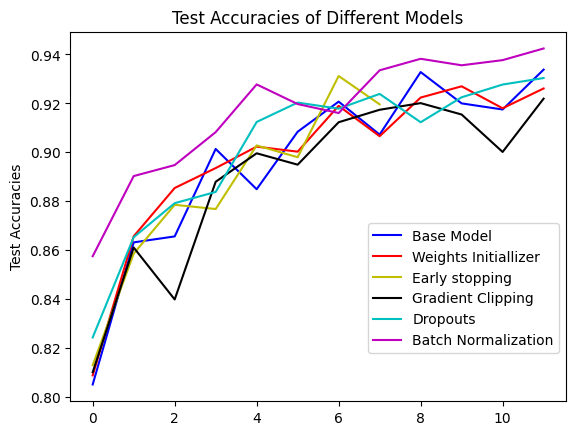

In [86]:
x_axis = range(num_epochs)
plt.ylabel("Test Accuracies")
plt.xlabel = "Number of Epochs"
plt.title("Test Accuracies of Different Models")
plt.plot(x_axis,acc_test_list,color="b",label="Base Model")
plt.plot(x_axis,acc_test_list1,color="r",label="Weights Initiallizer")
plt.plot(x_axis,acc_test_list2_md,color="y",label="Early stopping")
plt.plot(x_axis,acc_test_list3,color="k",label="Gradient Clipping")
plt.plot(x_axis,acc_test_list4,color="c",label="Dropouts")
plt.plot(x_axis,acc_test_list5,color="m",label="Batch Normalization")
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()

In [87]:
acc_train_list2_md = acc_train_list2 + [None,None,None,None]

In [90]:
acc_train_list2_md.pop()

In [91]:
len(acc_train_list2_md)

12

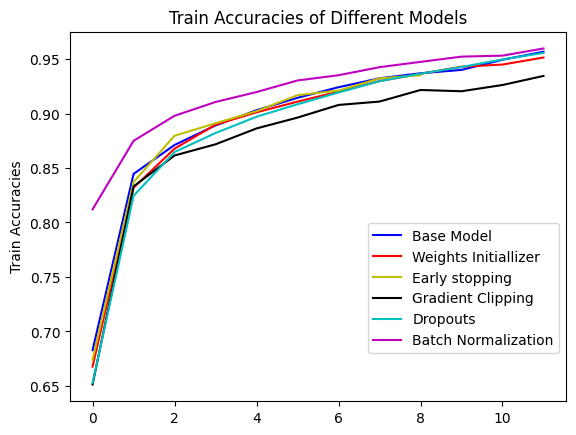

In [92]:
x_axis = range(num_epochs)
plt.ylabel("Train Accuracies")
plt.xlabel = "Number of Epochs"
plt.title("Train Accuracies of Different Models")
plt.plot(x_axis,acc_train_list,color="b",label="Base Model")
plt.plot(x_axis,acc_train_list1,color="r",label="Weights Initiallizer")
plt.plot(x_axis,acc_train_list2_md,color="y",label="Early stopping")
plt.plot(x_axis,acc_train_list3,color="k",label="Gradient Clipping")
plt.plot(x_axis,acc_train_list4,color="c",label="Dropouts")
plt.plot(x_axis,acc_train_list5,color="m",label="Batch Normalization")
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show()

In [94]:
print(len(loss_valid_list2))
loss_valid_list2_md = loss_valid_list2 +[None,None,None]

9


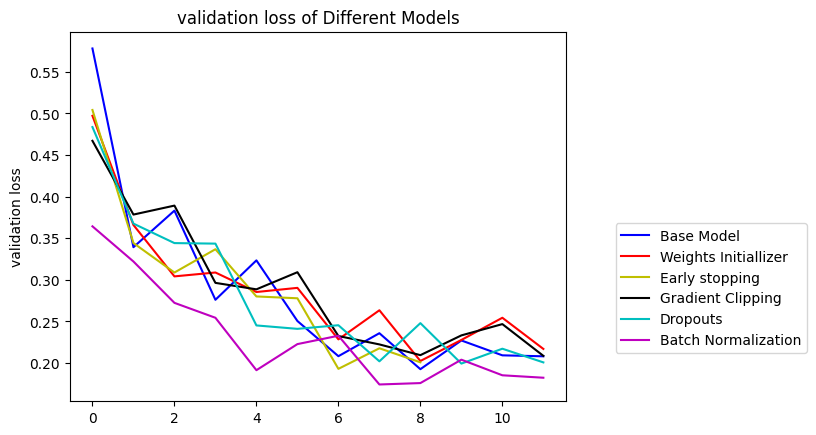

In [101]:
x_axis = range(num_epochs)
plt.ylabel("validation loss")
plt.xlabel = "Number of Epochs"
plt.title("validation loss of Different Models")
plt.plot(x_axis,loss_valid_list,color="b",label="Base Model")
plt.plot(x_axis,loss_valid_list1,color="r",label="Weights Initiallizer")
plt.plot(x_axis,loss_valid_list2_md,color="y",label="Early stopping")
plt.plot(x_axis,loss_valid_list3,color="k",label="Gradient Clipping")
plt.plot(x_axis,loss_valid_list4,color="c",label="Dropouts")
plt.plot(x_axis,loss_valid_list5,color="m",label="Batch Normalization")
plt.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

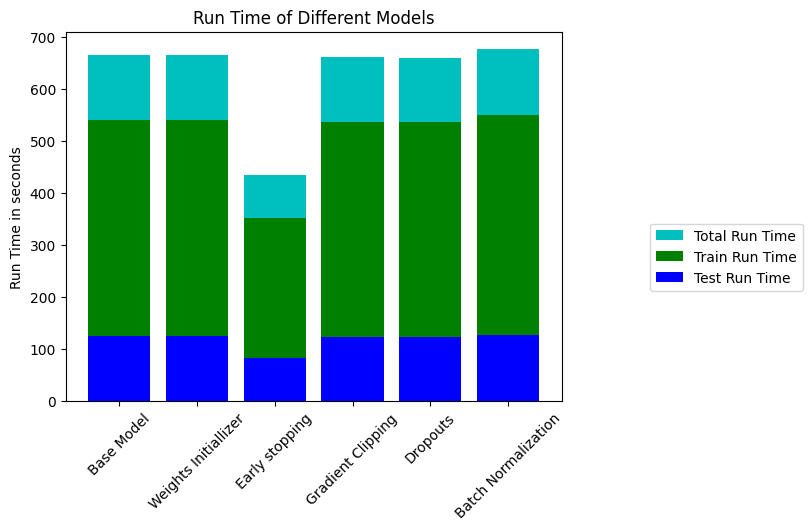

In [112]:
x_axis = ["Base Model","Weights Initiallizer","Early stopping","Gradient Clipping","Dropouts","Batch Normalization"]
plt.ylabel("Run Time in seconds")
plt.xlabel = "Models"
plt.title("Run Time of Different Models")
total_run_time_list = [sum(run_time_lst),sum(run_time_lst1),sum(run_time_lst2),sum(run_time_lst3),sum(run_time_lst4),sum(run_time_lst5)]
plt.bar(x_axis, total_run_time_list,label="Total Run Time",color="c")
train_run_time_list = [sum(run_time_train_lst),sum(run_time_train_lst1),sum(run_time_train_lst2),sum(run_time_train_lst3),sum(run_time_train_lst4),sum(run_time_train_lst5)]
test_run_time_list = [sum(run_time_test_lst),sum(run_time_test_lst1),sum(run_time_test_lst2),sum(run_time_test_lst3),sum(run_time_test_lst4),sum(run_time_test_lst5)]
plt.bar(x_axis, train_run_time_list,label="Train Run Time",color="g")
plt.bar(x_axis, test_run_time_list,label="Test Run Time",color='b')

plt.xticks(rotation=45)
plt.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

In [113]:
import numpy as np

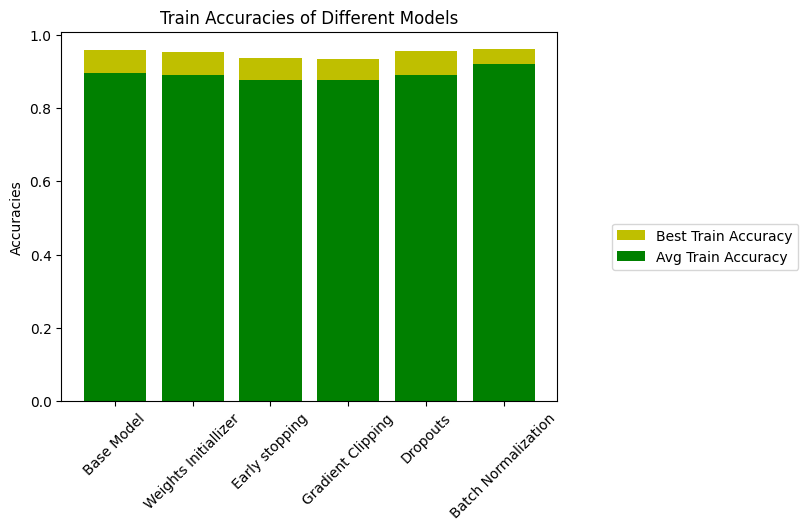

In [121]:
x_axis = ["Base Model","Weights Initiallizer","Early stopping","Gradient Clipping","Dropouts","Batch Normalization"]
plt.ylabel("Accuracies")
plt.xlabel = "Models"
plt.title("Train Accuracies of Different Models")
best_train_accuracies_list = [max(acc_train_list),max(acc_train_list1),max(acc_train_list2),max(acc_train_list3),max(acc_train_list4),max(acc_train_list5)]
plt.bar(x_axis, best_train_accuracies_list ,label="Best Train Accuracy",color="y")

avg_train_accuracies_list = [np.mean(acc_train_list),np.mean(acc_train_list1),np.mean(acc_train_list2),np.mean(acc_train_list3),np.mean(acc_train_list4),np.mean(acc_train_list5)]
plt.bar(x_axis, avg_train_accuracies_list ,label="Avg Train Accuracy",color="g")




plt.xticks(rotation=45)
plt.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

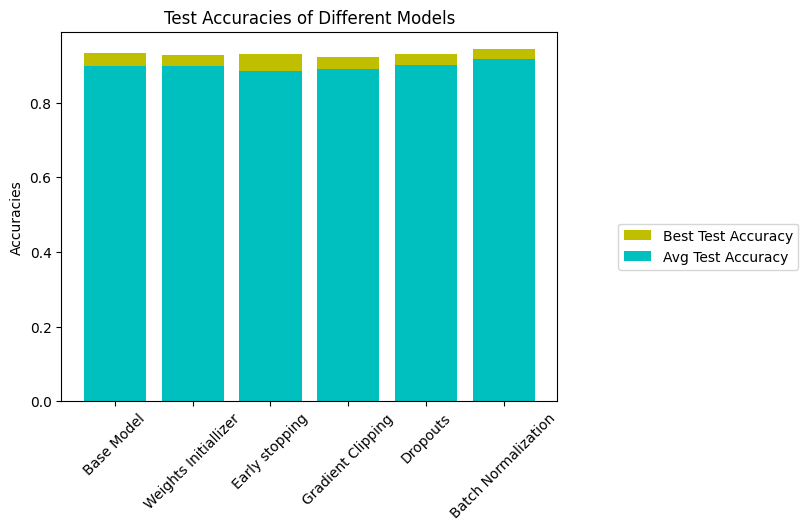

In [125]:
x_axis = ["Base Model","Weights Initiallizer","Early stopping","Gradient Clipping","Dropouts","Batch Normalization"]
plt.ylabel("Accuracies")
plt.xlabel = "Models"
plt.title("Test Accuracies of Different Models")

best_test_accuracies_list = [max(acc_test_list),max(acc_test_list1),max(acc_test_list2),max(acc_test_list3),max(acc_test_list4),max(acc_test_list5)]
plt.bar(x_axis, best_test_accuracies_list ,label="Best Test Accuracy",color="y")

avg_test_accuracies_list = [np.mean(acc_test_list),np.mean(acc_test_list1),np.mean(acc_test_list2),np.mean(acc_test_list3),np.mean(acc_test_list4),np.mean(acc_test_list5)]
plt.bar(x_axis, avg_test_accuracies_list ,label="Avg Test Accuracy",color="c")

plt.xticks(rotation=45)
plt.legend(loc='best', bbox_to_anchor=(1, 0., 0.5, 0.5))
plt.show()

# Documentation -- References 

https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
https://www.analyticsvidhya.com/blog/2021/05/how-to-use-progress-bars-in-python/

https://towardsdatascience.com/understand-kaiming-initialization-and-implementation-detail-in-pytorch-f7aa967e9138

https://www.youtube.com/watch?v=YA1OdkiHJBY
 
https://www.youtube.com/watch?v=7Fboe7_aTtY